# Чем чаще студент просматривает теорию, тем меньше они пересдают практику

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pytz
import matplotlib as mpl
import calendar
import statistics

In [43]:
# открывает таблицу "tries.csv" с пересдачами
d_parser = lambda x: pd.to_datetime(x, unit='s')
retries = pd.read_csv('C://Users//37529//Desktop//data since//2th sem//tries.csv', quotechar="'", delim_whitespace=False,
                    parse_dates=['timemodified'], date_parser=d_parser, 
                    usecols=['userid','courseid', 'number', 'timemodified'])
# Преобразование времени, сортируем по дате 
retries['timemodified'] = retries['timemodified'] + pd.Timedelta(hours=3)
retries = retries.sort_values(by='timemodified')
# выбираем определенный период времени для исследования (с 01.09.2022-1.03.2023)
retries_2022_2023=retries.loc[(retries['timemodified']>='2022-09-01')&(retries['timemodified']<'2023-01-31')]
# удаляем ненужные колонки
retries_2022_2023=retries_2022_2023.drop(columns = ['timemodified'], axis = 1) 
# вычисляем количество пересдач студента на разных элеменах одного курса
retries_2022_2023=retries_2022_2023.groupby(['userid', 'courseid'], as_index= False ).agg({'number': sum })
retries_2022_2023

,userid,courseid,number
0,144,34,1
1,144,177,4
2,144,324,4
3,265,179,1
4,266,179,10
...,...,...,...
174,24782,21,25
175,24785,21,9
176,24793,471,2
177,24795,213,2


In [44]:
# список айди всех курсов, в которых есть пересдачи
retries_courseid=list(retries_2022_2023.courseid.unique())
# список айди всех студентов, у которых есть пересдачи
retries_userid=list(retries_2022_2023.userid.unique())

len(retries_userid)

135

In [45]:
# загрузка  "DO(2022-2023).csv"
d_parser = lambda x: pd.to_datetime(x, unit='s')
logstore = pd.read_csv('C://Users//37529//Desktop//data since//2th sem//DO(2022-2023).csv', 
                       quotechar="'",delim_whitespace=True, parse_dates=['timecreated'], 
                       date_parser=d_parser, usecols=[ "userid","courseid","action", "objecttable", "timecreated"])
# Преобразование времени
logstore['timecreated'] = logstore['timecreated'] + pd.Timedelta(hours=3)
# сортируем по нужным нам курсам и по нужным студентам для анализа (в которых есть оценки)
logstore=logstore.query("courseid in @retries_courseid")
logstore=logstore.query("userid in @retries_userid")
# выбираем промежут времни
logstore=logstore.loc[(logstore['timecreated']>='2022-09-01')&(logstore['timecreated']<'2023-01-31')]
# Далее нам нужно выделить теоритические действия. Делаю выборку по ['viewed', 'reviewed', 'shown']
action = ['viewed', 'reviewed', 'shown']
logstore_theory = logstore[logstore["action"].isin(action)]
# выбираем теоритические элементы
elements = ['lesson', 'book', 'lesson_pages', 'page', 'folder','forum_discussions','resource','bigbluebuttonbn','book_chapters']
logstore_theory = logstore[logstore["objecttable"].isin(elements)]
# для дальнейшего анализа меняем значение в колонке 'action' на 'viewing theory', которое поможет нам в дальнейшем анализе
logstore_theory['action'] = logstore_theory['action'].replace(list(logstore_theory.action.unique()), 'viewing theory')
# удаляем ненужные колонки
logstore_theory=logstore_theory.drop(columns = ['objecttable','timecreated'], axis = 1) 
# подсчет количеста просмотра теории каждым студентом на каждом курсе
logstore_theory_1=logstore_theory.groupby (logstore_theory.columns.tolist (), as_index= False ). size ()
logstore_theory_1

C:\Users\37529\AppData\Local\Temp\ipykernel_19192\3798835485.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logstore_theory['action'] = logstore_theory['action'].replace(list(logstore_theory.action.unique()), 'viewing theory')


,action,userid,courseid,size
0,viewing theory,144,324,6
1,viewing theory,453,34,105
2,viewing theory,453,177,71
3,viewing theory,579,153,118
4,viewing theory,590,153,100
...,...,...,...,...
310,viewing theory,24795,213,51
311,viewing theory,24795,471,2
312,viewing theory,24795,4088,936
313,viewing theory,24795,5163,3


In [121]:
# создаем таблицу 'df_retries_theory', в которой содержится количество просмотров студентом теории на определенном курсе и
# количество пересдач на различных элементах данного курса
df_retries_theory=pd.DataFrame({'userid': [], 'courseid': [], 'number of retries':[], 'viewing theory':[]})
for i, row in retries_2022_2023.iterrows():
    for k, rows in logstore_theory_1.iterrows():
        if rows['userid']==row['userid'] and rows['courseid']==row['courseid']:
            df_retries_theory.loc[len(df_retries_theory.index)]=[row['userid'],row['courseid'],row['number'],rows['size']]
df_retries_theory

,userid,courseid,number of retries,viewing theory
0,144,324,4,6
1,453,34,2,105
2,579,153,12,118
3,590,153,3,100
4,591,153,12,101
...,...,...,...,...
111,24780,4088,2,431
112,24782,21,25,52
113,24785,21,9,52
114,24793,471,2,41


In [125]:
# удаление анамалий
df_retries_theory_1 = df_retries_theory.sort_values(by='viewing theory')
df_retries_theory_1 = df_retries_theory_1.loc[~df_retries_theory_1['viewing theory'].isin([0,431, 600])]
df_retries_theory_1

,userid,courseid,number of retries,viewing theory
79,19146,295,1,1
43,6525,324,4,2
29,2233,324,4,3
94,23327,309,2,4
110,24764,4065,2,5
...,...,...,...,...
1,453,34,2,105
76,17539,153,12,113
2,579,153,12,118
5,694,55,16,134


In [126]:
correlation= df_retries_theory_1['number of retries'].corr(df_retries_theory_1['viewing theory'])
correlation

0.5025049547424015

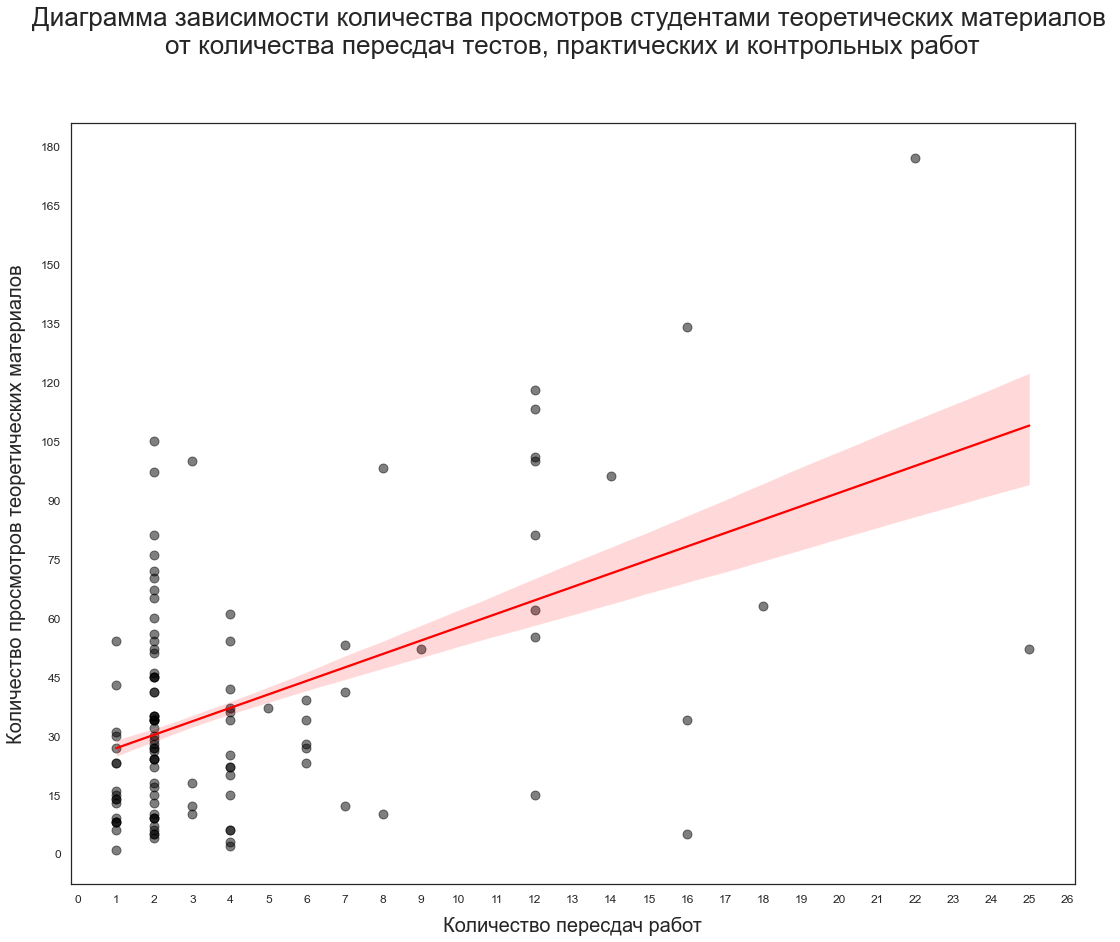

In [140]:
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.figure(figsize=(18, 14))
sns.regplot(x = df_retries_theory_1["number of retries"], y =df_retries_theory_1["viewing theory"], 
            scatter_kws = {"color": "black", "alpha": 0.5, "s": 80},
            line_kws = {"color": "red"},
            ci = 50)
plt.gcf().axes[0].yaxis.set_major_locator(ticker.MultipleLocator(15))
plt.gcf().axes[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Диаграмма зависимости количества просмотров студентами теоретических материалов \nот количества пересдач тестов, практических и контрольных работ', 
          size=26, pad = 70)
plt.xlabel('Количество пересдач работ',size=20, labelpad=12)
plt.ylabel('Количество просмотров теоретических материалов',size=20, labelpad=15) 
plt.savefig('Диаграмма рассеяния.pdf')

<AxesSubplot:xlabel='number of retries', ylabel='viewing theory'>

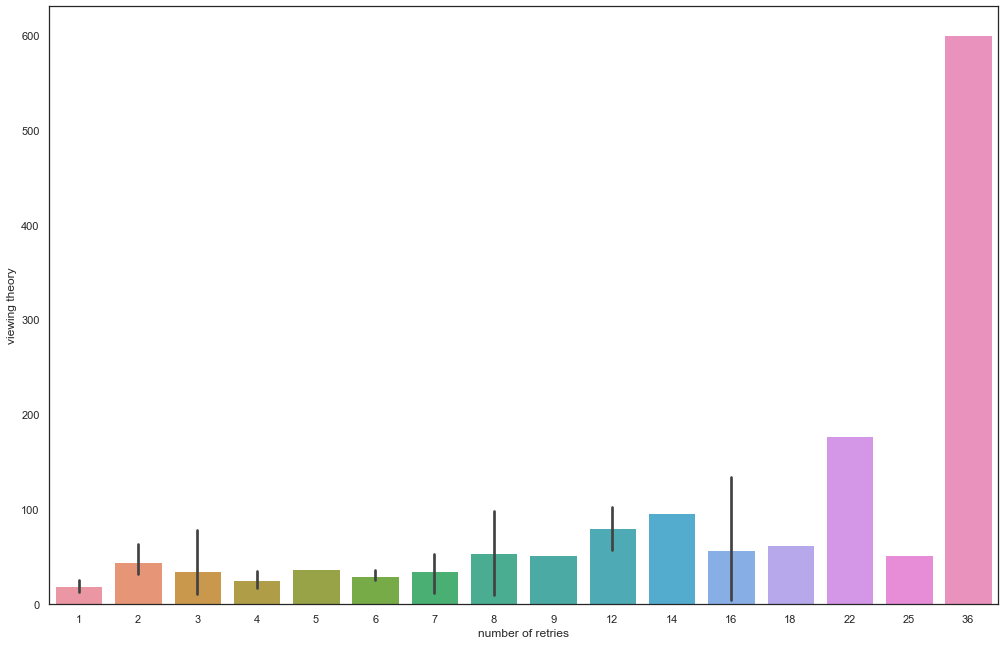

In [59]:
plt.figure(figsize=(17, 11))
sns.barplot(data=df_retries_theory_1, x ="number of retries", y ="viewing theory")

# 